In [ ]:
!pip install segmentation_models

In [2]:
import tensorflow as tf
import segmentation_models as sm
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import pandas as pd
import pickle

from skimage.filters import *

from tensorflow.keras.metrics import *
from tensorflow.keras.utils import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
# Zip project for submission
#!zip -r '/content/drive/MyDrive/Colab Notebooks/Code Tasks/Biotrillion-Segmentation.zip' '/content/drive/MyDrive/Colab Notebooks/Code Tasks/Biotrillion-Segmentation'

In [4]:
# task parameters
SIZE_X = 160 
SIZE_Y = 224
n_classes=3  #Number of classes for segmentation

# define folder paths for project & data
proj_fp = Path(os.getcwd())/"drive/MyDrive/Colab Notebooks/Code Tasks/Biotrillion-Segmentation"
data_fp = proj_fp/"L2-data"
train_data_fp = data_fp/"training_set"
test_data_fp = data_fp/"testing_set"

# Get data index 
train_data_index = pd.read_csv(train_data_fp/"data_index.csv", index_col='img_id')
test_data_index = pd.read_csv(test_data_fp/"data_index.csv", index_col='img_id')
#test_data_index.head(2)

In [5]:
# Get input and target image data 
def get_xy_imgs(data_index: pd.DataFrame,
                x_col: str, y_col: str):
    """
    get images based on index dataframe
        parameters 
            data_index (pd.DataFrame): dataframe with file index
            x_col, y_col (str): name of column for paths of image x and y
    """
    img_id = data_index.index
    x_imgs = [cv2.imread(str(data_index.loc[i][x_col]), 1) for i in img_id]
    y_imgs = [cv2.imread(str(data_index.loc[i][y_col]), -1) for i in img_id]
    return np.asarray(x_imgs), np.asarray(y_imgs)

#Encode labels... but multi dim array so need to flatten, encode and reshape
def OHencode_masks(masks: np.array):
    """
    One-hot encoding of masks provided as array
    """
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    masks_reshaped_encoded = labelencoder.fit_transform(masks.reshape(-1,1))
    masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)

    masks_input = np.expand_dims(masks_encoded_original_shape, axis=3)
    masks_cat = to_categorical(masks_input, num_classes=n_classes)
    masks_cat.reshape((n, h, w, n_classes))
    return masks_cat

In [6]:
# Get train images for standardization
train_images, train_masks = get_xy_imgs(train_data_index, x_col="x_img-path", y_col="y_img-path")
train_masks_input = OHencode_masks(train_masks)
X_train, y_train = train_images, train_masks_input
# Get test image for testing
test_images, test_masks = get_xy_imgs(test_data_index, x_col='x_img-path', y_col='y_img-path')
test_masks_input = OHencode_masks(test_masks)
X_test, y_test = test_images, test_masks_input
#print(X_test.shape, y_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# Define loss
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

In [47]:
# choose class of trained models
choice = 1
mcp_name =  ["Unet_transfer-vgg/",
             "Unet_transfer-FPN/",
             "U2net_transfer-vgg/"][choice]
print("Available models:\n", os.listdir(proj_fp/'Models'/mcp_name))

Available models:
 ['.E23-L0.09(datagen-prepreprocessing).h5', '.E94-L0.11(sm-preprocessing).h5']


In [50]:
model_file = [".E159-L0.09(custom-preprocessing).h5",  #Unet_transfer-vgg/",
              ".E94-L0.11(sm-preprocessing).h5",   #Unet_transfer-FPN/"
              ".E72-L0.09(custom-preprocessing).h5",   #U2net_transfer-vgg/"
              ][choice]

model_name = mcp_name + model_file
#Set compile=False as we are not loading it for training, only for prediction.
model = load_model(proj_fp/'Models'/model_name,
                    custom_objects={'f1-score': sm.metrics.FScore(threshold=0.5),
                                    'total_loss': total_loss},
                    compile=False)
# Load data generator
with open(data_fp/"generator"/mcp_name/"test_generator.pkl","rb") as f: test_datagen = pickle.load(f)

In [53]:
# Preprocessing : Must follow training parameter
preprocessing = True
# preprocessing input if needed
if preprocessing:
    x_test = sm.get_preprocessing('vgg16')(X_test)
else:
    x_test = X_test

# Make prediction
y_pred = model.predict(test_datagen.flow(x_test, y_test, shuffle=False))

#Weighted average ensemble (if use ensemble)

# model_weighting = [0.5, 0.5]
# weighted_preds = np.tensordot(np.array([pred1, pred2]),model_weighting , axes=((0),(0)))

In [54]:
# Define evaluation metric
def iou(y_true, y_pred, e=1e-9):
    """
    compute IOU with y_true, y_pred: 3d numpy array of shape (h,w,c)
    """
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + e) / (union + e)
        return x.astype(np.float32)
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def get_iou(y_pred:np.array, y_true:np.array,
            img_id: pd.Index, ch_axis:dict={'pupil':0, 'iris':1}) -> pd.DataFrame:
    """
    return iou for predictions as a dataframe
        parameters:
            ch_axis: channel axis for each class to be evluated 
                    # 0 is background, 1: iris, 2: pupil
    """
    label = {'pupil':1, 'iris':2}
    assert len(img_id)== len(y_pred)== len(y_true)
    iou_ = {k: list() for k in ch_axis.keys()}
    for i in range(len(img_id)):
        for name, c in ch_axis.items():
            iou_[name].append(iou(y_pred[i][:,:,c], y_test[i][:,:,label[name]]))
    return pd.DataFrame(iou_, index=img_id)

# Compute IOU
iou_df = get_iou(y_pred, y_test, test_data_index.index, 
                 ch_axis={'pupil':0, 'iris':1})
# Save result to csv
#iou_df.to_csv(proj_fp/"Results"/("Model-"+model_name.replace('/','_')+"-iou.csv"))
print("\nMean IOU:\n"+str(iou_df.mean()))


Mean IOU:
pupil    0.823400
iris     0.830336
dtype: float64


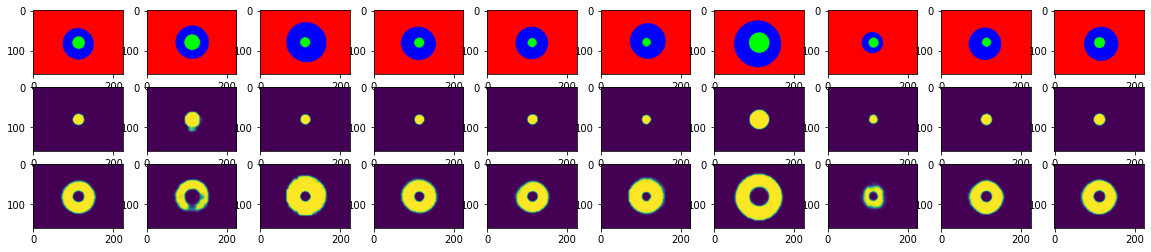

In [57]:
# Qucik visualization
def plot_all_pred(pred_array:np.array, true_array: np.array, ch_axis:dict=[1,2]):
    """
    plot all predictions from array (n, h, w, c)
    """ 
    fig, ax = plt.subplots(3, len(pred_array), figsize=(2*len(pred_array),4))
    for n, p in enumerate(pred_array):
        ax[0, n].imshow(true_array[n])
        ax[1, n].imshow(p[:,:,ch_axis[0]])
        ax[2, n].imshow(p[:,:,ch_axis[1]])
plot_all_pred(y_pred, y_test, ch_axis=[0,1])

# Analysis - Dimater

In [ ]:
# Read data_index csv
test_data_index = pd.read_csv(test_data_fp/"data_index.csv").set_index('img_id')

#test_data_index.head(2)

In [ ]:
def expand_meta_df(data_index: pd.DataFrame) ->pd.DataFrame:
    """
    populate meta info to data index
    """
    def get_meta_info(x: pd.Series):
        """
        help function: load meta info
        """
        with open(x['meta-path']) as f: meta_data = yaml.safe_load(f)
        x['iris-info'] = meta_data['iris']['ellipse_params']
        x['pupil-info'] = meta_data['pupil']['ellipse_params']
        return x
    data_index = data_index.copy()
    # get meta info as a column
    meta_col = data_index.apply(get_meta_info, axis=1)
    return meta_col
# Add meta info to data table
test_data_index = expand_meta_df(test_data_index)
#test_data_index.head(2)

In [ ]:
def blur_filter(im:np.array):
    """
    Apply blurring filter and threshold to binary image
        parameters:
            im: image (2d, 3d)
        returns
            np.array, dtype: uint8
    """
    # blur before thresholding
    blurred_image = gaussian(im, sigma=3)
    # perform adaptive thresholding to produce a binary image
    t = threshold_otsu(blurred_image)
    return (blurred_image > t).astype('uint8')

def find_contours(im: np.array, plot: bool=False, closing_ks: tuple=(5,5)):
    """
    Compute and find contours in masks
    parameters:
        im: image (2d, 3d)
        plot: show plot?
        clonsing_ks: morphological closing kernel size 
    """
    # apply filtering
    im_bin = blur_filter(im)
    # perform morphological closing to remove noise
    im_bin = cv2.morphologyEx(im_bin, cv2.MORPH_CLOSE, np.ones(closing_ks, np.uint8))
    _, pred = cv2.threshold(im_bin, 0, 255, cv2.THRESH_BINARY)  # stretch 
    im_color = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
    # Find full contour tree without chain approximation
    contours, hierarchy = cv2.findContours(pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if plot: 
        plt.imshow(im_bin)
        cv2.drawContours(im_color, contours, -1, (255,0,0), 1)
    return contours

def largest_enclosed_radius(contours:list, im:np.array=None, plot: bool=False):
    """
    find largest enclosed radius of objects based on contour object
        parameters:
            contour: hierachical contours outputted from cv2.findContours
            im: image for plotting (optional)
            bool: show plot? (optional)
    """
    cnt = contours
    radius_best = 0; center_best = (0,0)
    for i in range (len(cnt)):
        center, radius = cv2.minEnclosingCircle(cnt[i])
        if radius >= radius_best:
            center_best = center
            radius_best = radius
    if plot and im is not None:
        fig, ax = plt.subplots(1)
        ax.text(10, -10, 'Centre: '+str(center_best), fontsize=11, color = 'red')
        ax.text(244, -10, 'Diameter: '+str((radius_best*2)/100)+'mm', fontsize=11, color = 'red')
        ax.imshow(im, cmap='gray')
        ax.add_artist(plt.Circle(center_best, radius_best ,color='red', fill=False))
    return center_best, np.round(radius_best,2)

def get_eye_info(predictions: np.array, ch_axis: dict={'iris':1, 'pupil':0}):
    """
    final function to compute centre and radius of iris & pupil
        predictions:
            pred: 3d array (h, w, c)
            ch_axis: channel axis of image that refers to iris and pupil
                len(ch_axis) == 2
    """
    eye_data = {'iris':[], 'pupil':[]}
    for name, ch in ch_axis.items():
        part_data = []
        for p_im in predictions:
            contours = find_contours(p_im[:,:, ch])
            center, radius = largest_enclosed_radius(contours, p_im)
            part_data.append({'center':center, 'radius': radius})
        eye_data[name] = pd.DataFrame(part_data)
    return pd.concat(eye_data, axis=1)

# Generate prediction tables for predicted diameters metrics for each class
pred_eye_info = get_eye_info(y_pred,
                             ch_axis={'iris':1, 'pupil':0})
#pred_eye_info.head(2)

((114.1603775024414, 80.23584747314453), 10.71)

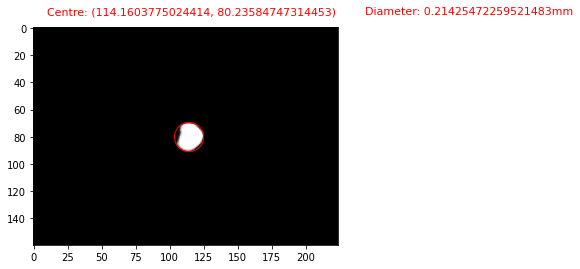

In [ ]:
# Test contour finding function
im = y_pred[5][:,:,0]
contours = find_contours(im)
largest_enclosed_radius(contours,im, plot=True)


Mean error%

iris-error     5.871046
pupil-error    9.349446
dtype: float64


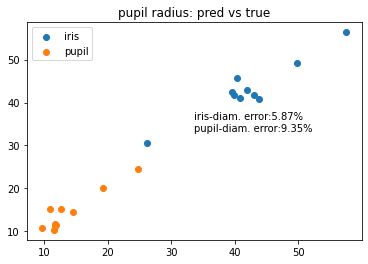

In [ ]:
def evaluate_agreement(data_df: pd.DataFrame, 
                       pred_df: np.array,
                       plot: bool = False) -> pd.DataFrame:
    """
    compare true iris/pupil radius with predictions
        paramters:
            data_df (pd.DataFrame): needs to contain columns 'iris-info' and 'pupil-info'
            pred_df (pd.DataFrame): needs to contain columns 'iris' and 'pupil'
    """
    assert len(data_df) == len(pred_df)
    data_df = data_df.copy()
    pred_df.index = data_df.index
    # get true radius (long axisZz)
    iris_radius = data_df.apply(lambda x: x['iris-info']['radius_y'], axis=1)
    pupil_radius = data_df.apply(lambda x: x['pupil-info']['radius_y'], axis=1)
    # Compute error, store in dataframe
    error_df = pd.concat(
        {'iris-error': (iris_radius-pred_df.iris.radius).abs()/iris_radius*100,
        'pupil-error': (pupil_radius-pred_df.pupil.radius).abs()/pupil_radius*100
         }, axis=1)
    if plot:    # optional linear regress plotting
        fig, ax = plt.subplots(1)
        ax.scatter(iris_radius, pred_df.iris.radius); plt.title("iris radius: pred vs true")
        ax.scatter(pupil_radius, pred_df.pupil.radius); plt.title("pupil radius: pred vs true")
        ax.text(0.5,0.5, "iris-diam. error:{:.2f}%\npupil-diam. error:{:.2f}%".format(
            error_df.mean()['iris-error'], error_df.mean()['pupil-error']), transform = ax.transAxes)
        ax.legend(['iris','pupil'])
    return error_df
        
error_df = evaluate_agreement(test_data_index, pred_eye_info, plot=True)
# Save results
#error_df.to_csv(proj_fp/"Results"/("Model-"+model_name.replace('/','_')+"-errors.csv"))
print("\nMean error%\n"); print(error_df.mean())

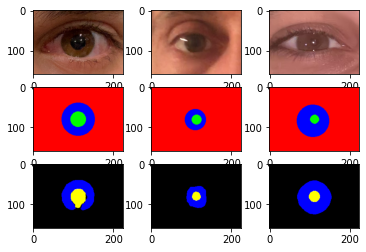

In [58]:
# inspect the images & prediction for more understanding
img_id = ['000008491_Ycrop_Hres_R','000008962_Ycrop_Hres_L','000009122_Ycrop_Hres_L']
def plot_inspect_images_pred(img_id: list, pred_array:np.array, ch_axis=[0,1]):
    """
    compare image with 
    """
    fig, ax = plt.subplots(3, len(img_id))
    for n, imd in enumerate(img_id):    # plot ground truth images
        ax[0, n].imshow(plt.imread(test_data_index.loc[imd]['x_img-path']))
        ax[1, n].imshow(plt.imread(test_data_index.loc[imd]['y_input_img-path']))
        for r,ch in enumerate(ch_axis):  # plot predicted iris & pupil
            pred_im = pred_array[test_data_index.index.get_loc(imd)]
            ax[2, n].imshow(np.concatenate([np.expand_dims(pred_im[:,:,0],axis=2),
                                            pred_im[:,:]], axis=-1))

plot_inspect_images_pred(img_id, np.round(y_pred))